In [ ]:
using PyPlot

using Distributed
using SharedArrays

addprocs(4)

@everywhere include("../src/num.jl")
@everywhere include("../src/phy.jl")
@everywhere using .num
@everywhere using .physics

@everywhere using DSP

In [2]:
const t = 0.5
U = 3.2
T = 0.0
const nωn = 2^12
const nω = 2^12
ωrange = [-16.0,16.0]
const zeroplus = 0.01
const itermax = 200
const tol = 0.01
const mix = 0.80;

In [3]:
ω = range(ωrange[1],length=nω,stop=ωrange[2])
ω = convert(Array{Float64},ω);

In [4]:
@time D0ω = baredos.("cubic",t,ω);
gloc = zeros(ComplexF64,nω,2);

  0.530662 seconds (1.76 M allocations: 124.580 MiB, 7.05% gc time)


In [5]:
@everywhere function ipt_solver(Aw, nf, U)
    Ap = Aw[:,1] .* nf
    Am = Aw[:,2] .* nf
    App = conv_same(Ap,Ap)
    Appp = conv_same(Am, App)
    return -π .* U^2 .* (Appp + Appp[end:-1:1])

    return -π .* U^2 .* (AAB + BBA)
end

@everywhere function ipt_selfcons(ω,dos,t,U,T,itermax,nω,zeroplus,mix,tol)
        gloc = zeros(ComplexF64,nω,2)
        g0 = zeros(ComplexF64,nω,2)
        isi = zeros(Float64,nω,2)
        hsi = zeros(Float64,nω,2)
        A0 = zeros(Float64,nω,2)
        Σ2 = zeros(ComplexF64,nω,2)

        magnet = 0.0

        dω = ω[2] - ω[1]

        nf = fermi.(ω,T)

        η = zeroplus
        α = mix

        ρe = dos[1:4:nω]
        w  = ω[1:4:nω]

        Σ1 = U .* [0.9 -0.9]
    
        for i = 1:nω
            ζ_up = zeta(ω[i] - Σ1[1],η)
            ζ_down = zeta(ω[i] - Σ1[2],η)
        
            intg = ρe ./ (ζ_up*ζ_down .- w.^2.)
            sum = trapz(w,intg)
        
            gloc[i,1] = sum * ζ_down
            gloc[i,2] = sum * ζ_up
        end
        
        for iter = 1:itermax

            gloc_old = deepcopy(gloc)

            ncalc = zeros(Float64,length(gloc[1,:]))
            @fastmath @inbounds for i in 1:2
                ncalc[i] = -1/π .* trapz(ω,imag(gloc[:,i]) .* nf)
            end
        
            Σ1[1] = U .* (ncalc[2] - sum(ncalc)/2)
            Σ1[2] = U .* (ncalc[1] - sum(ncalc)/2)
            magnet = (ncalc[2] - ncalc[1]) / sum(ncalc)
        
            g0[:,1] = 1. ./ (ω .+ im*η .- t^2 .* gloc_old[:,2])
            g0[:,2] = 1. ./ (ω .+ im*η .- t^2 .* gloc_old[:,1])
            
            for i = 1:2 A0[:,i] = -imag(g0[:,i]) ./ π end
        
            for i = 1:2
                isi[:,i] = ipt_solver(A0,nf,U) * dω * dω
                isi[:,i] = 0.5 .* (isi[:,i] + isi[end:-1:1,i])
                hsi[:,i] = -imag.(Util.hilbert(isi[:,i]))
            end

            Σ2 = hsi .+ im .* isi

            for i = 1:nω
                ζ_up = zeta(ω[i] - Σ1[1] .- Σ2[i,1],η)
                ζ_down = zeta(ω[i] - Σ1[2] .- Σ2[i,2],η)

                intg = ρe ./ (ζ_up*ζ_down .- w.^2.)
                sum = trapz(w,intg)

                gloc[i,1] = sum * ζ_down
                gloc[i,2] = sum * ζ_up
            end

            convg, error = convergent(gloc_old,gloc,ω,nω,tol)

            if convg == false
                gloc = mixing(gloc_old,gloc,mix)
            elseif iter == itermax
                println("Convergent is not achieved. Try Lower Mixings or Higher Iterations")
                break
            elseif convg == true
                println("Convergent is achieved for U = $U, and T = $T K")
                break
            end
        end

        return gloc,Σ2,magnet

end;

In [31]:
nU = 50
U = range(0.0, length=nU,stop=7.5)
U = convert(Array{Float64},U)

nT = 50
T = range(0.0, length=nT,stop=1000)
T = convert(Array{Float64},T)

magnet = SharedArray{Float64}(nU,nT)

@inbounds @sync @distributed for iU in 1:nU
    for iT in 1:nT
        _,_,magnet[iU,iT] =  ipt_selfcons(ω,D0ω,t,U[iU],T[iT],itermax,nω,zeroplus,mix,tol)
    end
end

      From worker 2:	Convergent is achieved for U = 0.0, and T = 0.0 K
      From worker 2:	Convergent is achieved for U = 0.0, and T = 20.408163265306122 K
      From worker 2:	Convergent is achieved for U = 0.0, and T = 40.816326530612244 K
      From worker 2:	Convergent is achieved for U = 0.0, and T = 61.224489795918366 K
      From worker 2:	Convergent is achieved for U = 0.0, and T = 81.63265306122449 K
      From worker 2:	Convergent is achieved for U = 0.0, and T = 102.04081632653062 K
      From worker 2:	Convergent is achieved for U = 0.0, and T = 122.44897959183673 K
      From worker 4:	Convergent is achieved for U = 3.979591836734694, and T = 0.0 K
      From worker 5:	Convergent is achieved for U = 5.816326530612245, and T = 0.0 K
      From worker 2:	Convergent is achieved for U = 0.0, and T = 142.85714285714286 K
      From worker 2:	Convergent is achieved for U = 0.0, and T = 163.26530612244898 K
      From worker 2:	Convergent is achieved for U = 0.0, and T = 183.673

      From worker 5:	Convergent is achieved for U = 5.816326530612245, and T = 244.89795918367346 K
      From worker 2:	Convergent is achieved for U = 0.15306122448979592, and T = 204.08163265306123 K
      From worker 4:	Convergent is achieved for U = 3.979591836734694, and T = 224.48979591836735 K
      From worker 2:	Convergent is achieved for U = 0.15306122448979592, and T = 224.48979591836735 K
      From worker 5:	Convergent is achieved for U = 5.816326530612245, and T = 265.3061224489796 K
      From worker 2:	Convergent is achieved for U = 0.15306122448979592, and T = 244.89795918367346 K
      From worker 4:	Convergent is achieved for U = 3.979591836734694, and T = 244.89795918367346 K
      From worker 3:	Convergent is achieved for U = 1.989795918367347, and T = 163.26530612244898 K
      From worker 2:	Convergent is achieved for U = 0.15306122448979592, and T = 265.3061224489796 K
      From worker 5:	Convergent is achieved for U = 5.816326530612245, and T = 285.71428571428

      From worker 4:	Convergent is achieved for U = 3.979591836734694, and T = 612.2448979591836 K
      From worker 5:	Convergent is achieved for U = 5.816326530612245, and T = 612.2448979591836 K
      From worker 2:	Convergent is achieved for U = 0.15306122448979592, and T = 959.1836734693877 K
      From worker 3:	Convergent is achieved for U = 1.989795918367347, and T = 326.53061224489795 K
      From worker 4:	Convergent is achieved for U = 3.979591836734694, and T = 632.6530612244898 K
      From worker 2:	Convergent is achieved for U = 0.15306122448979592, and T = 979.5918367346939 K
      From worker 5:	Convergent is achieved for U = 5.816326530612245, and T = 632.6530612244898 K
      From worker 2:	Convergent is achieved for U = 0.15306122448979592, and T = 1000.0 K
      From worker 4:	Convergent is achieved for U = 3.979591836734694, and T = 653.0612244897959 K
      From worker 5:	Convergent is achieved for U = 5.816326530612245, and T = 653.0612244897959 K
      From wor

      From worker 2:	Convergent is achieved for U = 0.30612244897959184, and T = 551.0204081632653 K
      From worker 3:	Convergent is achieved for U = 1.989795918367347, and T = 591.8367346938776 K
      From worker 5:	Convergent is achieved for U = 5.816326530612245, and T = 1000.0 K
      From worker 2:	Convergent is achieved for U = 0.30612244897959184, and T = 571.4285714285714 K
      From worker 2:	Convergent is achieved for U = 0.30612244897959184, and T = 591.8367346938776 K
      From worker 4:	Convergent is achieved for U = 4.13265306122449, and T = 20.408163265306122 K
      From worker 3:	Convergent is achieved for U = 1.989795918367347, and T = 612.2448979591836 K
      From worker 5:	Convergent is achieved for U = 5.969387755102041, and T = 0.0 K
      From worker 2:	Convergent is achieved for U = 0.30612244897959184, and T = 612.2448979591836 K
      From worker 2:	Convergent is achieved for U = 0.30612244897959184, and T = 632.6530612244898 K
      From worker 3:	Conv

      From worker 3:	Convergent is achieved for U = 1.989795918367347, and T = 959.1836734693877 K
      From worker 2:	Convergent is achieved for U = 0.45918367346938777, and T = 163.26530612244898 K
      From worker 4:	Convergent is achieved for U = 4.13265306122449, and T = 346.9387755102041 K
      From worker 5:	Convergent is achieved for U = 5.969387755102041, and T = 346.9387755102041 K
      From worker 3:	Convergent is achieved for U = 1.989795918367347, and T = 979.5918367346939 K
      From worker 2:	Convergent is achieved for U = 0.45918367346938777, and T = 183.6734693877551 K
      From worker 4:	Convergent is achieved for U = 4.13265306122449, and T = 367.3469387755102 K
      From worker 5:	Convergent is achieved for U = 5.969387755102041, and T = 367.3469387755102 K
      From worker 2:	Convergent is achieved for U = 0.45918367346938777, and T = 204.08163265306123 K
      From worker 3:	Convergent is achieved for U = 1.989795918367347, and T = 1000.0 K
      From work

      From worker 2:	Convergent is achieved for U = 0.45918367346938777, and T = 734.6938775510204 K
      From worker 4:	Convergent is achieved for U = 4.13265306122449, and T = 775.5102040816327 K
      From worker 2:	Convergent is achieved for U = 0.45918367346938777, and T = 755.1020408163265 K
      From worker 5:	Convergent is achieved for U = 5.969387755102041, and T = 755.1020408163265 K
      From worker 4:	Convergent is achieved for U = 4.13265306122449, and T = 795.9183673469388 K
      From worker 3:	Convergent is achieved for U = 2.142857142857143, and T = 224.48979591836735 K
      From worker 2:	Convergent is achieved for U = 0.45918367346938777, and T = 775.5102040816327 K
      From worker 2:	Convergent is achieved for U = 0.45918367346938777, and T = 795.9183673469388 K
      From worker 4:	Convergent is achieved for U = 4.13265306122449, and T = 816.3265306122449 K
      From worker 5:	Convergent is achieved for U = 5.969387755102041, and T = 775.5102040816327 K
    

      From worker 4:	Convergent is achieved for U = 4.285714285714286, and T = 163.26530612244898 K
      From worker 2:	Convergent is achieved for U = 0.6122448979591837, and T = 285.7142857142857 K
      From worker 5:	Convergent is achieved for U = 6.122448979591836, and T = 163.26530612244898 K
      From worker 4:	Convergent is achieved for U = 4.285714285714286, and T = 183.6734693877551 K
      From worker 3:	Convergent is achieved for U = 2.142857142857143, and T = 510.2040816326531 K
      From worker 2:	Convergent is achieved for U = 0.6122448979591837, and T = 306.1224489795918 K
      From worker 5:	Convergent is achieved for U = 6.122448979591836, and T = 183.6734693877551 K
      From worker 4:	Convergent is achieved for U = 4.285714285714286, and T = 204.08163265306123 K
      From worker 2:	Convergent is achieved for U = 0.6122448979591837, and T = 326.53061224489795 K
      From worker 3:	Convergent is achieved for U = 2.142857142857143, and T = 530.6122448979592 K
   

      From worker 2:	Convergent is achieved for U = 0.6122448979591837, and T = 795.9183673469388 K
      From worker 3:	Convergent is achieved for U = 2.142857142857143, and T = 877.5510204081633 K
      From worker 5:	Convergent is achieved for U = 6.122448979591836, and T = 551.0204081632653 K
      From worker 4:	Convergent is achieved for U = 4.285714285714286, and T = 591.8367346938776 K
      From worker 2:	Convergent is achieved for U = 0.6122448979591837, and T = 816.3265306122449 K
      From worker 3:	Convergent is achieved for U = 2.142857142857143, and T = 897.9591836734694 K
      From worker 2:	Convergent is achieved for U = 0.6122448979591837, and T = 836.734693877551 K
      From worker 5:	Convergent is achieved for U = 6.122448979591836, and T = 571.4285714285714 K
      From worker 4:	Convergent is achieved for U = 4.285714285714286, and T = 612.2448979591836 K
      From worker 2:	Convergent is achieved for U = 0.6122448979591837, and T = 857.1428571428571 K
      F

      From worker 2:	Convergent is achieved for U = 0.7653061224489796, and T = 224.48979591836735 K
      From worker 3:	Convergent is achieved for U = 2.295918367346939, and T = 204.08163265306123 K
      From worker 5:	Convergent is achieved for U = 6.122448979591836, and T = 1000.0 K
      From worker 4:	Convergent is achieved for U = 4.438775510204081, and T = 40.816326530612244 K
      From worker 2:	Convergent is achieved for U = 0.7653061224489796, and T = 244.89795918367346 K
      From worker 3:	Convergent is achieved for U = 2.295918367346939, and T = 224.48979591836735 K
      From worker 5:	Convergent is achieved for U = 6.275510204081633, and T = 0.0 K
      From worker 4:	Convergent is achieved for U = 4.438775510204081, and T = 61.224489795918366 K
      From worker 2:	Convergent is achieved for U = 0.7653061224489796, and T = 265.3061224489796 K
      From worker 3:	Convergent is achieved for U = 2.295918367346939, and T = 244.89795918367346 K
      From worker 5:	Conv

      From worker 5:	Convergent is achieved for U = 6.275510204081633, and T = 428.57142857142856 K
      From worker 2:	Convergent is achieved for U = 0.7653061224489796, and T = 734.6938775510204 K
      From worker 4:	Convergent is achieved for U = 4.438775510204081, and T = 489.7959183673469 K
      From worker 5:	Convergent is achieved for U = 6.275510204081633, and T = 448.9795918367347 K
      From worker 3:	Convergent is achieved for U = 2.295918367346939, and T = 510.2040816326531 K
      From worker 2:	Convergent is achieved for U = 0.7653061224489796, and T = 755.1020408163265 K
      From worker 4:	Convergent is achieved for U = 4.438775510204081, and T = 510.2040816326531 K
      From worker 2:	Convergent is achieved for U = 0.7653061224489796, and T = 775.5102040816327 K
      From worker 5:	Convergent is achieved for U = 6.275510204081633, and T = 469.38775510204084 K
      From worker 3:	Convergent is achieved for U = 2.295918367346939, and T = 530.6122448979592 K
     

      From worker 5:	Convergent is achieved for U = 6.275510204081633, and T = 857.1428571428571 K
      From worker 3:	Convergent is achieved for U = 2.295918367346939, and T = 918.3673469387755 K
      From worker 2:	Convergent is achieved for U = 0.9183673469387755, and T = 102.04081632653062 K
      From worker 4:	Convergent is achieved for U = 4.438775510204081, and T = 959.1836734693877 K
      From worker 5:	Convergent is achieved for U = 6.275510204081633, and T = 877.5510204081633 K
      From worker 3:	Convergent is achieved for U = 2.295918367346939, and T = 938.7755102040817 K
      From worker 4:	Convergent is achieved for U = 4.438775510204081, and T = 979.5918367346939 K
      From worker 5:	Convergent is achieved for U = 6.275510204081633, and T = 897.9591836734694 K
      From worker 2:	Convergent is achieved for U = 0.9183673469387755, and T = 122.44897959183673 K
      From worker 3:	Convergent is achieved for U = 2.295918367346939, and T = 959.1836734693877 K
      

      From worker 4:	Convergent is achieved for U = 4.591836734693878, and T = 367.3469387755102 K
      From worker 2:	Convergent is achieved for U = 0.9183673469387755, and T = 489.7959183673469 K
      From worker 5:	Convergent is achieved for U = 6.428571428571429, and T = 326.53061224489795 K
      From worker 4:	Convergent is achieved for U = 4.591836734693878, and T = 387.7551020408163 K
      From worker 2:	Convergent is achieved for U = 0.9183673469387755, and T = 510.2040816326531 K
      From worker 5:	Convergent is achieved for U = 6.428571428571429, and T = 346.9387755102041 K
      From worker 4:	Convergent is achieved for U = 4.591836734693878, and T = 408.16326530612247 K
      From worker 2:	Convergent is achieved for U = 0.9183673469387755, and T = 530.6122448979592 K
      From worker 3:	Convergent is achieved for U = 2.4489795918367347, and T = 285.7142857142857 K
      From worker 5:	Convergent is achieved for U = 6.428571428571429, and T = 367.3469387755102 K
    

      From worker 4:	Convergent is achieved for U = 4.591836734693878, and T = 836.734693877551 K
      From worker 3:	Convergent is achieved for U = 2.4489795918367347, and T = 571.4285714285714 K
      From worker 2:	Convergent is achieved for U = 0.9183673469387755, and T = 979.5918367346939 K
      From worker 5:	Convergent is achieved for U = 6.428571428571429, and T = 775.5102040816327 K
      From worker 4:	Convergent is achieved for U = 4.591836734693878, and T = 857.1428571428571 K
      From worker 3:	Convergent is achieved for U = 2.4489795918367347, and T = 591.8367346938776 K
      From worker 2:	Convergent is achieved for U = 0.9183673469387755, and T = 1000.0 K
      From worker 5:	Convergent is achieved for U = 6.428571428571429, and T = 795.9183673469388 K
      From worker 4:	Convergent is achieved for U = 4.591836734693878, and T = 877.5510204081633 K
      From worker 3:	Convergent is achieved for U = 2.4489795918367347, and T = 612.2448979591836 K
      From worker

      From worker 4:	Convergent is achieved for U = 4.744897959183674, and T = 285.7142857142857 K
      From worker 3:	Convergent is achieved for U = 2.6020408163265305, and T = 61.224489795918366 K
      From worker 5:	Convergent is achieved for U = 6.581632653061225, and T = 244.89795918367346 K
      From worker 4:	Convergent is achieved for U = 4.744897959183674, and T = 306.1224489795918 K
      From worker 2:	Convergent is achieved for U = 1.0714285714285714, and T = 204.08163265306123 K
      From worker 5:	Convergent is achieved for U = 6.581632653061225, and T = 265.3061224489796 K
      From worker 3:	Convergent is achieved for U = 2.6020408163265305, and T = 81.63265306122449 K
      From worker 4:	Convergent is achieved for U = 4.744897959183674, and T = 326.53061224489795 K
      From worker 5:	Convergent is achieved for U = 6.581632653061225, and T = 285.7142857142857 K
      From worker 4:	Convergent is achieved for U = 4.744897959183674, and T = 346.9387755102041 K
   

      From worker 5:	Convergent is achieved for U = 6.581632653061225, and T = 734.6938775510204 K
      From worker 2:	Convergent is achieved for U = 1.0714285714285714, and T = 551.0204081632653 K
      From worker 4:	Convergent is achieved for U = 4.744897959183674, and T = 816.3265306122449 K
      From worker 3:	Convergent is achieved for U = 2.6020408163265305, and T = 387.7551020408163 K
      From worker 5:	Convergent is achieved for U = 6.581632653061225, and T = 755.1020408163265 K
      From worker 2:	Convergent is achieved for U = 1.0714285714285714, and T = 571.4285714285714 K
      From worker 4:	Convergent is achieved for U = 4.744897959183674, and T = 836.734693877551 K
      From worker 3:	Convergent is achieved for U = 2.6020408163265305, and T = 408.16326530612247 K
      From worker 5:	Convergent is achieved for U = 6.581632653061225, and T = 775.5102040816327 K
      From worker 4:	Convergent is achieved for U = 4.744897959183674, and T = 857.1428571428571 K
      

      From worker 3:	Convergent is achieved for U = 2.6020408163265305, and T = 816.3265306122449 K
      From worker 4:	Convergent is achieved for U = 4.8979591836734695, and T = 183.6734693877551 K
      From worker 2:	Convergent is achieved for U = 1.0714285714285714, and T = 1000.0 K
      From worker 5:	Convergent is achieved for U = 6.73469387755102, and T = 142.85714285714286 K
      From worker 3:	Convergent is achieved for U = 2.6020408163265305, and T = 836.734693877551 K
      From worker 4:	Convergent is achieved for U = 4.8979591836734695, and T = 204.08163265306123 K
      From worker 5:	Convergent is achieved for U = 6.73469387755102, and T = 163.26530612244898 K
      From worker 3:	Convergent is achieved for U = 2.6020408163265305, and T = 857.1428571428571 K
      From worker 4:	Convergent is achieved for U = 4.8979591836734695, and T = 224.48979591836735 K
      From worker 5:	Convergent is achieved for U = 6.73469387755102, and T = 183.6734693877551 K
      From wor

      From worker 3:	Convergent is achieved for U = 2.7551020408163267, and T = 244.89795918367346 K
      From worker 5:	Convergent is achieved for U = 6.73469387755102, and T = 673.469387755102 K
      From worker 4:	Convergent is achieved for U = 4.8979591836734695, and T = 734.6938775510204 K
      From worker 5:	Convergent is achieved for U = 6.73469387755102, and T = 693.8775510204082 K
      From worker 4:	Convergent is achieved for U = 4.8979591836734695, and T = 755.1020408163265 K
      From worker 3:	Convergent is achieved for U = 2.7551020408163267, and T = 265.3061224489796 K
      From worker 4:	Convergent is achieved for U = 4.8979591836734695, and T = 775.5102040816327 K
      From worker 2:	Convergent is achieved for U = 1.2244897959183674, and T = 142.85714285714286 K
      From worker 5:	Convergent is achieved for U = 6.73469387755102, and T = 714.2857142857143 K
      From worker 3:	Convergent is achieved for U = 2.7551020408163267, and T = 285.7142857142857 K
     

      From worker 5:	Convergent is achieved for U = 6.887755102040816, and T = 142.85714285714286 K
      From worker 2:	Convergent is achieved for U = 1.2244897959183674, and T = 387.7551020408163 K
      From worker 4:	Convergent is achieved for U = 5.051020408163265, and T = 183.6734693877551 K
      From worker 3:	Convergent is achieved for U = 2.7551020408163267, and T = 734.6938775510204 K
      From worker 5:	Convergent is achieved for U = 6.887755102040816, and T = 163.26530612244898 K
      From worker 4:	Convergent is achieved for U = 5.051020408163265, and T = 204.08163265306123 K
      From worker 3:	Convergent is achieved for U = 2.7551020408163267, and T = 755.1020408163265 K
      From worker 2:	Convergent is achieved for U = 1.2244897959183674, and T = 408.16326530612247 K
      From worker 5:	Convergent is achieved for U = 6.887755102040816, and T = 183.6734693877551 K
      From worker 3:	Convergent is achieved for U = 2.7551020408163267, and T = 775.5102040816327 K
 

      From worker 3:	Convergent is achieved for U = 2.9081632653061225, and T = 142.85714285714286 K
      From worker 5:	Convergent is achieved for U = 6.887755102040816, and T = 591.8367346938776 K
      From worker 2:	Convergent is achieved for U = 1.2244897959183674, and T = 755.1020408163265 K
      From worker 4:	Convergent is achieved for U = 5.051020408163265, and T = 632.6530612244898 K
      From worker 3:	Convergent is achieved for U = 2.9081632653061225, and T = 163.26530612244898 K
      From worker 5:	Convergent is achieved for U = 6.887755102040816, and T = 612.2448979591836 K
      From worker 2:	Convergent is achieved for U = 1.2244897959183674, and T = 775.5102040816327 K
      From worker 4:	Convergent is achieved for U = 5.051020408163265, and T = 653.0612244897959 K
      From worker 5:	Convergent is achieved for U = 6.887755102040816, and T = 632.6530612244898 K
      From worker 2:	Convergent is achieved for U = 1.2244897959183674, and T = 795.9183673469388 K
   

      From worker 4:	Convergent is achieved for U = 5.204081632653061, and T = 81.63265306122449 K
      From worker 5:	Convergent is achieved for U = 7.040816326530612, and T = 81.63265306122449 K
      From worker 3:	Convergent is achieved for U = 2.9081632653061225, and T = 571.4285714285714 K
      From worker 4:	Convergent is achieved for U = 5.204081632653061, and T = 102.04081632653062 K
      From worker 5:	Convergent is achieved for U = 7.040816326530612, and T = 102.04081632653062 K
      From worker 3:	Convergent is achieved for U = 2.9081632653061225, and T = 591.8367346938776 K
      From worker 3:	Convergent is achieved for U = 2.9081632653061225, and T = 612.2448979591836 K
      From worker 4:	Convergent is achieved for U = 5.204081632653061, and T = 122.44897959183673 K
      From worker 5:	Convergent is achieved for U = 7.040816326530612, and T = 122.44897959183673 K
      From worker 3:	Convergent is achieved for U = 2.9081632653061225, and T = 632.6530612244898 K
  

      From worker 4:	Convergent is achieved for U = 5.204081632653061, and T = 612.2448979591836 K
      From worker 5:	Convergent is achieved for U = 7.040816326530612, and T = 612.2448979591836 K
      From worker 3:	Convergent is achieved for U = 3.061224489795918, and T = 102.04081632653062 K
      From worker 4:	Convergent is achieved for U = 5.204081632653061, and T = 632.6530612244898 K
      From worker 5:	Convergent is achieved for U = 7.040816326530612, and T = 632.6530612244898 K
      From worker 3:	Convergent is achieved for U = 3.061224489795918, and T = 122.44897959183673 K
      From worker 2:	Convergent is achieved for U = 1.3775510204081634, and T = 122.44897959183673 K
      From worker 4:	Convergent is achieved for U = 5.204081632653061, and T = 653.0612244897959 K
      From worker 5:	Convergent is achieved for U = 7.040816326530612, and T = 653.0612244897959 K
      From worker 3:	Convergent is achieved for U = 3.061224489795918, and T = 142.85714285714286 K
     

      From worker 4:	Convergent is achieved for U = 5.357142857142857, and T = 102.04081632653062 K
      From worker 3:	Convergent is achieved for U = 3.061224489795918, and T = 571.4285714285714 K
      From worker 5:	Convergent is achieved for U = 7.1938775510204085, and T = 122.44897959183673 K
      From worker 3:	Convergent is achieved for U = 3.061224489795918, and T = 591.8367346938776 K
      From worker 4:	Convergent is achieved for U = 5.357142857142857, and T = 122.44897959183673 K
      From worker 2:	Convergent is achieved for U = 1.3775510204081634, and T = 306.1224489795918 K
      From worker 5:	Convergent is achieved for U = 7.1938775510204085, and T = 142.85714285714286 K
      From worker 3:	Convergent is achieved for U = 3.061224489795918, and T = 612.2448979591836 K
      From worker 4:	Convergent is achieved for U = 5.357142857142857, and T = 142.85714285714286 K
      From worker 5:	Convergent is achieved for U = 7.1938775510204085, and T = 163.26530612244898 K


      From worker 4:	Convergent is achieved for U = 5.357142857142857, and T = 551.0204081632653 K
      From worker 5:	Convergent is achieved for U = 7.1938775510204085, and T = 571.4285714285714 K
      From worker 3:	Convergent is achieved for U = 3.2142857142857144, and T = 40.816326530612244 K
      From worker 4:	Convergent is achieved for U = 5.357142857142857, and T = 571.4285714285714 K
      From worker 2:	Convergent is achieved for U = 1.3775510204081634, and T = 612.2448979591836 K
      From worker 5:	Convergent is achieved for U = 7.1938775510204085, and T = 591.8367346938776 K
      From worker 3:	Convergent is achieved for U = 3.2142857142857144, and T = 61.224489795918366 K
      From worker 4:	Convergent is achieved for U = 5.357142857142857, and T = 591.8367346938776 K
      From worker 2:	Convergent is achieved for U = 1.3775510204081634, and T = 632.6530612244898 K
      From worker 5:	Convergent is achieved for U = 7.1938775510204085, and T = 612.2448979591836 K
 

      From worker 3:	Convergent is achieved for U = 3.2142857142857144, and T = 408.16326530612247 K
      From worker 5:	Convergent is achieved for U = 7.346938775510204, and T = 0.0 K
      From worker 3:	Convergent is achieved for U = 3.2142857142857144, and T = 428.57142857142856 K
      From worker 4:	Convergent is achieved for U = 5.510204081632653, and T = 0.0 K
      From worker 5:	Convergent is achieved for U = 7.346938775510204, and T = 20.408163265306122 K
      From worker 3:	Convergent is achieved for U = 3.2142857142857144, and T = 448.9795918367347 K
      From worker 2:	Convergent is achieved for U = 1.530612244897959, and T = 0.0 K
      From worker 4:	Convergent is achieved for U = 5.510204081632653, and T = 20.408163265306122 K
      From worker 3:	Convergent is achieved for U = 3.2142857142857144, and T = 469.38775510204084 K
      From worker 5:	Convergent is achieved for U = 7.346938775510204, and T = 40.816326530612244 K
      From worker 3:	Convergent is achieve

      From worker 4:	Convergent is achieved for U = 5.510204081632653, and T = 469.38775510204084 K
      From worker 3:	Convergent is achieved for U = 3.2142857142857144, and T = 979.5918367346939 K
      From worker 2:	Convergent is achieved for U = 1.530612244897959, and T = 142.85714285714286 K
      From worker 5:	Convergent is achieved for U = 7.346938775510204, and T = 510.2040816326531 K
      From worker 4:	Convergent is achieved for U = 5.510204081632653, and T = 489.7959183673469 K
      From worker 3:	Convergent is achieved for U = 3.2142857142857144, and T = 1000.0 K
      From worker 5:	Convergent is achieved for U = 7.346938775510204, and T = 530.6122448979592 K
      From worker 4:	Convergent is achieved for U = 5.510204081632653, and T = 510.2040816326531 K
      From worker 3:	Convergent is achieved for U = 3.36734693877551, and T = 0.0 K
      From worker 5:	Convergent is achieved for U = 7.346938775510204, and T = 551.0204081632653 K
      From worker 4:	Convergent 

      From worker 2:	Convergent is achieved for U = 1.530612244897959, and T = 244.89795918367346 K
      From worker 4:	Convergent is achieved for U = 5.663265306122449, and T = 0.0 K
      From worker 3:	Convergent is achieved for U = 3.36734693877551, and T = 469.38775510204084 K
      From worker 5:	Convergent is achieved for U = 7.5, and T = 40.816326530612244 K
      From worker 3:	Convergent is achieved for U = 3.36734693877551, and T = 489.7959183673469 K
      From worker 4:	Convergent is achieved for U = 5.663265306122449, and T = 20.408163265306122 K
      From worker 5:	Convergent is achieved for U = 7.5, and T = 61.224489795918366 K
      From worker 3:	Convergent is achieved for U = 3.36734693877551, and T = 510.2040816326531 K
      From worker 2:	Convergent is achieved for U = 1.530612244897959, and T = 265.3061224489796 K
      From worker 4:	Convergent is achieved for U = 5.663265306122449, and T = 40.816326530612244 K
      From worker 5:	Convergent is achieved for U

      From worker 5:	Convergent is achieved for U = 7.5, and T = 510.2040816326531 K
      From worker 4:	Convergent is achieved for U = 5.663265306122449, and T = 469.38775510204084 K
      From worker 3:	Convergent is achieved for U = 3.520408163265306, and T = 0.0 K
      From worker 4:	Convergent is achieved for U = 5.663265306122449, and T = 489.7959183673469 K
      From worker 5:	Convergent is achieved for U = 7.5, and T = 530.6122448979592 K
      From worker 2:	Convergent is achieved for U = 1.530612244897959, and T = 530.6122448979592 K
      From worker 3:	Convergent is achieved for U = 3.520408163265306, and T = 20.408163265306122 K
      From worker 4:	Convergent is achieved for U = 5.663265306122449, and T = 510.2040816326531 K
      From worker 5:	Convergent is achieved for U = 7.5, and T = 551.0204081632653 K
      From worker 2:	Convergent is achieved for U = 1.530612244897959, and T = 551.0204081632653 K
      From worker 3:	Convergent is achieved for U = 3.5204081632

      From worker 3:	Convergent is achieved for U = 3.520408163265306, and T = 408.16326530612247 K
      From worker 2:	Convergent is achieved for U = 1.530612244897959, and T = 938.7755102040817 K
      From worker 4:	Convergent is achieved for U = 5.663265306122449, and T = 959.1836734693877 K
      From worker 5:	Convergent is achieved for U = 7.5, and T = 1000.0 K
      From worker 3:	Convergent is achieved for U = 3.520408163265306, and T = 428.57142857142856 K
      From worker 2:	Convergent is achieved for U = 1.530612244897959, and T = 959.1836734693877 K
      From worker 4:	Convergent is achieved for U = 5.663265306122449, and T = 979.5918367346939 K
      From worker 3:	Convergent is achieved for U = 3.520408163265306, and T = 448.9795918367347 K
      From worker 2:	Convergent is achieved for U = 1.530612244897959, and T = 979.5918367346939 K
      From worker 4:	Convergent is achieved for U = 5.663265306122449, and T = 1000.0 K
      From worker 3:	Convergent is achieved 

      From worker 3:	Convergent is achieved for U = 3.673469387755102, and T = 551.0204081632653 K
      From worker 3:	Convergent is achieved for U = 3.673469387755102, and T = 571.4285714285714 K
      From worker 2:	Convergent is achieved for U = 1.683673469387755, and T = 387.7551020408163 K
      From worker 3:	Convergent is achieved for U = 3.673469387755102, and T = 591.8367346938776 K
      From worker 2:	Convergent is achieved for U = 1.683673469387755, and T = 408.16326530612247 K
      From worker 3:	Convergent is achieved for U = 3.673469387755102, and T = 612.2448979591836 K
      From worker 3:	Convergent is achieved for U = 3.673469387755102, and T = 632.6530612244898 K
      From worker 2:	Convergent is achieved for U = 1.683673469387755, and T = 428.57142857142856 K
      From worker 3:	Convergent is achieved for U = 3.673469387755102, and T = 653.0612244897959 K
      From worker 3:	Convergent is achieved for U = 3.673469387755102, and T = 673.469387755102 K
      Fro

      From worker 3:	Convergent is achieved for U = 3.826530612244898, and T = 510.2040816326531 K
      From worker 2:	Convergent is achieved for U = 1.836734693877551, and T = 102.04081632653062 K
      From worker 3:	Convergent is achieved for U = 3.826530612244898, and T = 530.6122448979592 K
      From worker 3:	Convergent is achieved for U = 3.826530612244898, and T = 551.0204081632653 K
      From worker 2:	Convergent is achieved for U = 1.836734693877551, and T = 122.44897959183673 K
      From worker 3:	Convergent is achieved for U = 3.826530612244898, and T = 571.4285714285714 K
      From worker 3:	Convergent is achieved for U = 3.826530612244898, and T = 591.8367346938776 K
      From worker 2:	Convergent is achieved for U = 1.836734693877551, and T = 142.85714285714286 K
      From worker 3:	Convergent is achieved for U = 3.826530612244898, and T = 612.2448979591836 K
      From worker 3:	Convergent is achieved for U = 3.826530612244898, and T = 632.6530612244898 K
      F

Task (done) @0x00007f3722cdc7f0

In [41]:
using JLD2
@save "ipt_ph_diagram_antifero.jld2" magnet U T

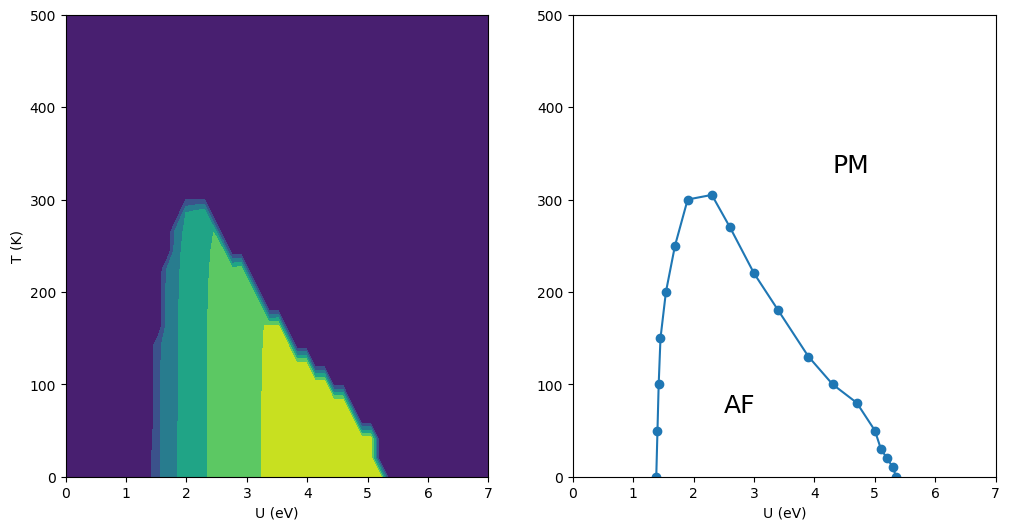

In [97]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)

plt.contourf(U,T,transpose(magnet[:,:]),cmap="viridis")
plt.ylim(0,500)
plt.xlim(0,7)
plt.ylabel("T (K)")
plt.xlabel("U (eV)")

plt.subplot(1,2,2)
y = [0, 50, 100, 150, 200, 250, 300, 305, 270, 220, 180, 130, 100, 80, 50, 30, 20, 10, 0]
x = [1.38, 1.4, 1.42, 1.45, 1.54, 1.69, 1.9, 2.3, 2.6, 3.0, 3.4, 3.9, 4.3, 4.7, 5.0, 5.1, 5.2, 5.3, 5.35]
plt.ylim(0,500)
plt.xlim(0,7)
plt.plot(x,y,"-o")
plt.xlabel("U (eV)")

plt.text(2.5,70,"AF",fontsize=18)
plt.text(4.3,330,"PM",fontsize=18)

plt.show()
plt.savefig("ipt_ph_diagram_antiferro.pdf",format="pdf")